In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import hipp
from pathlib import Path
import matplotlib.pyplot as plt

## Settings

In [4]:
# Paths
PROJECT_DIRECTORY = Path("/home/godinlu/Documents/history_remote/data_final/casa_grande/kh9_pc_images/1978_03_25")
RAW_IMAGES = PROJECT_DIRECTORY / "raw_images"
JOINED_IMAGES = Path("/home/godinlu/Documents/history_remote/output/test_kh9pc_preproc/casa_grande/joined_images")
PREPROCESSED_IMAGES = Path("/home/godinlu/Documents/history_remote/output/test_kh9pc_preproc/casa_grande/preprocessed_images")
#CROPPING_BORDERS_FILE = os.path.join(PROJECT_DIRECTORY, "cropping_borders.csv")

QUICKVIEW_FACTOR = 0.05

In [ ]:
hipp.kh9pc.join_images(RAW_IMAGES, JOINED_IMAGES)

In [6]:
hipp.tools.generate_quickviews(JOINED_IMAGES, QUICKVIEW_FACTOR, max_workers=5)

Generating quickviews: 100%|██████████| 2/2 [07:17<00:00, 218.89s/image]


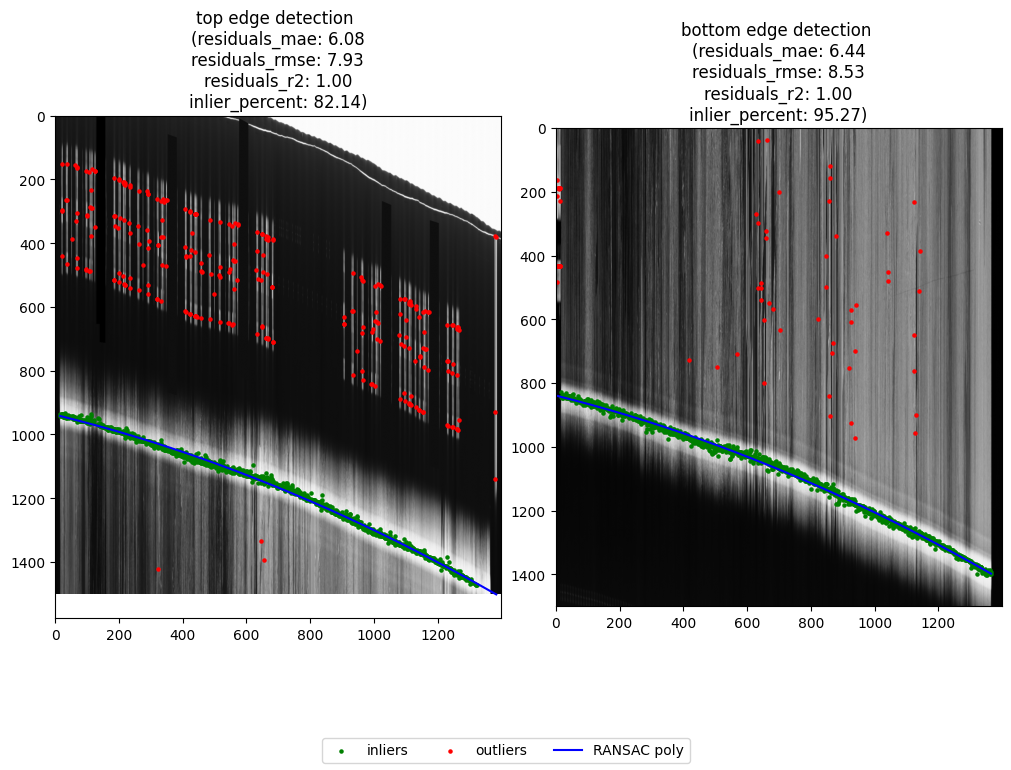

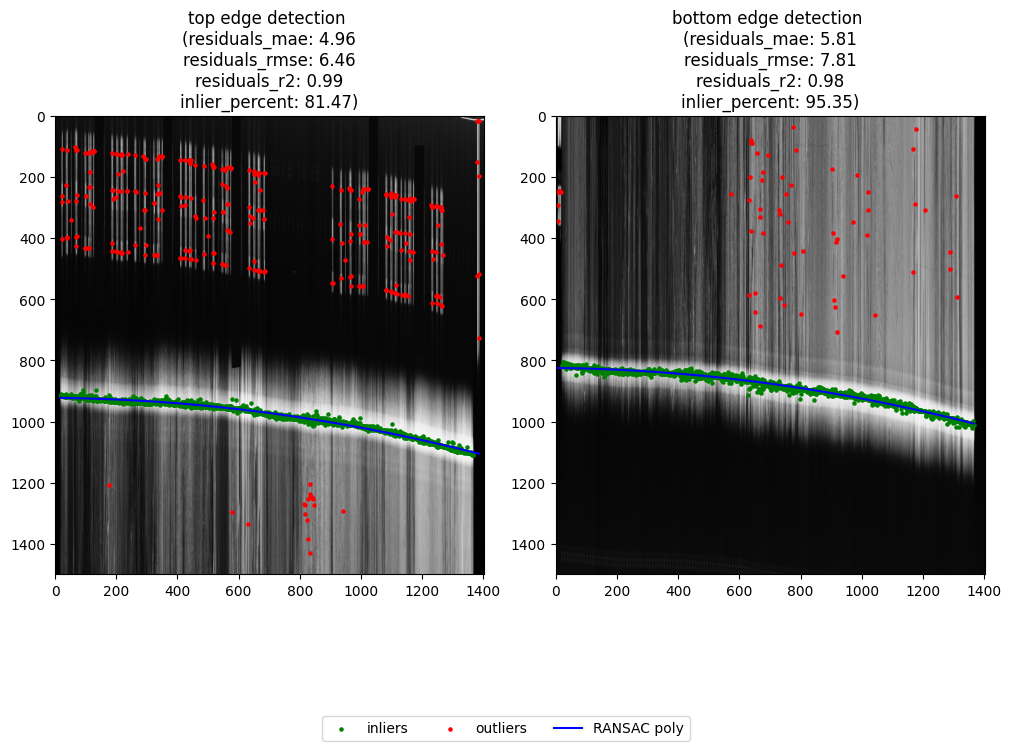

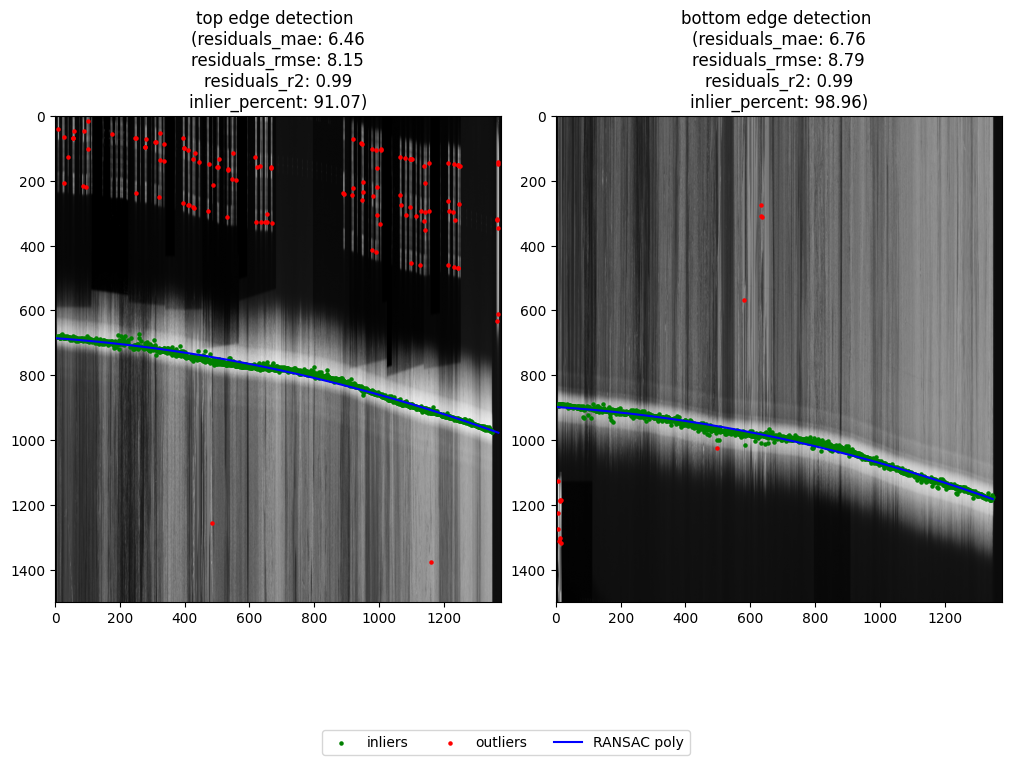

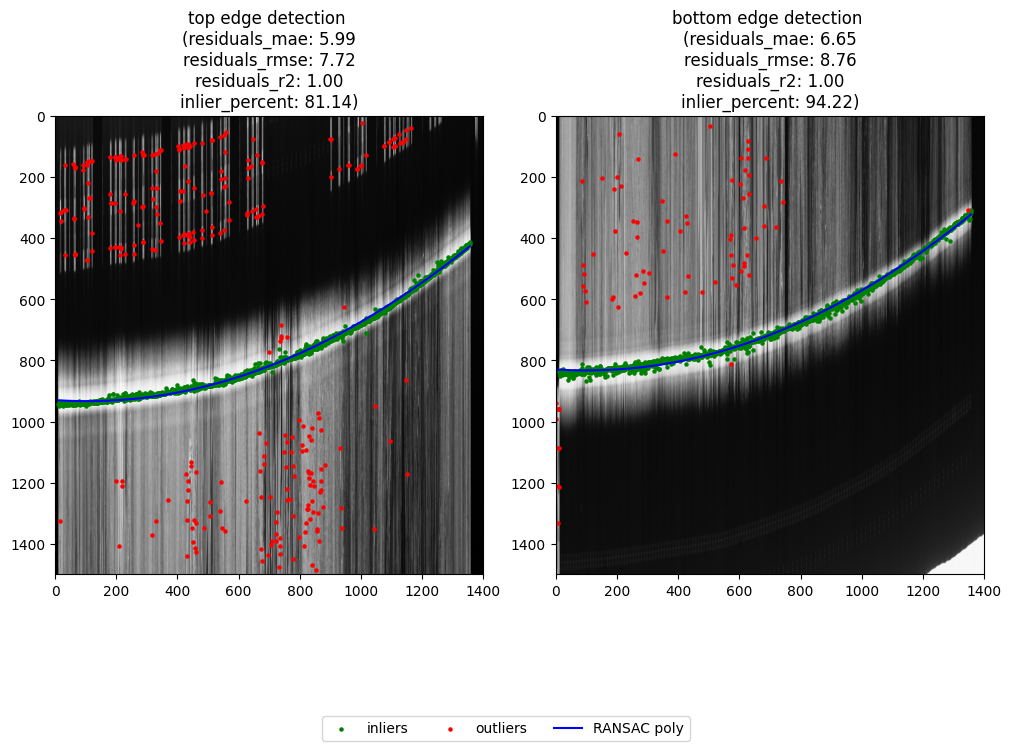

In [6]:
collimation_lines_dict = {}
for raster_filepath in JOINED_IMAGES.glob("*.tif"):
    collimation_lines_dict[raster_filepath.name] = hipp.kh9pc.lines_processing.detect_horizontal_collimation_lines(raster_filepath)


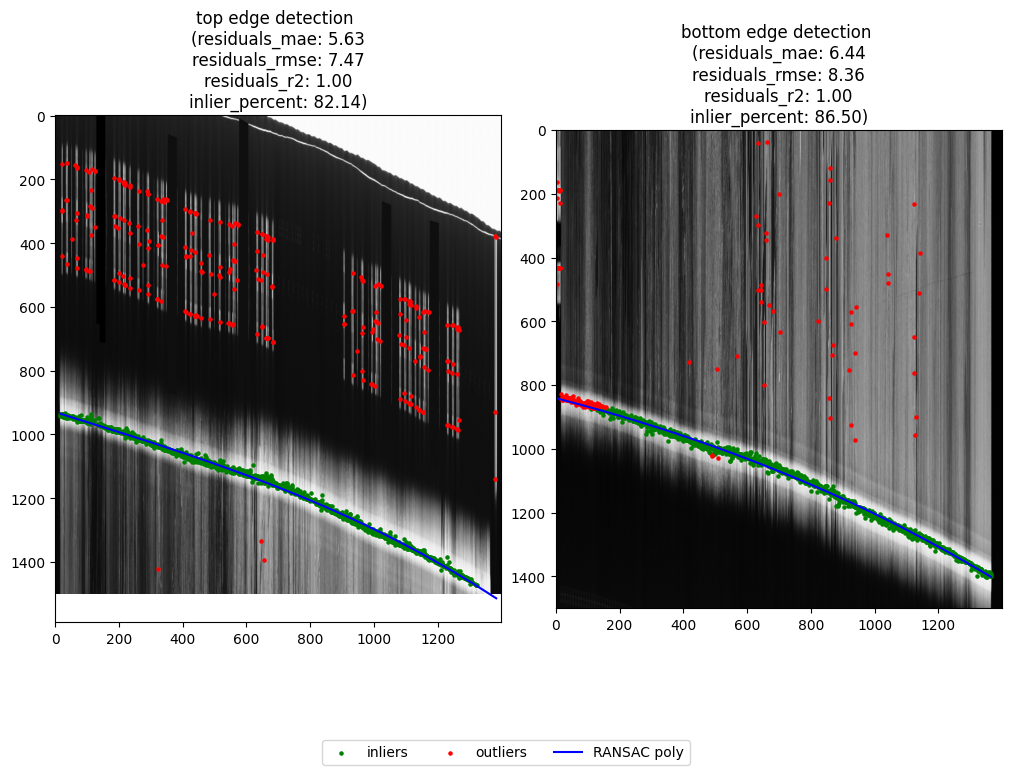

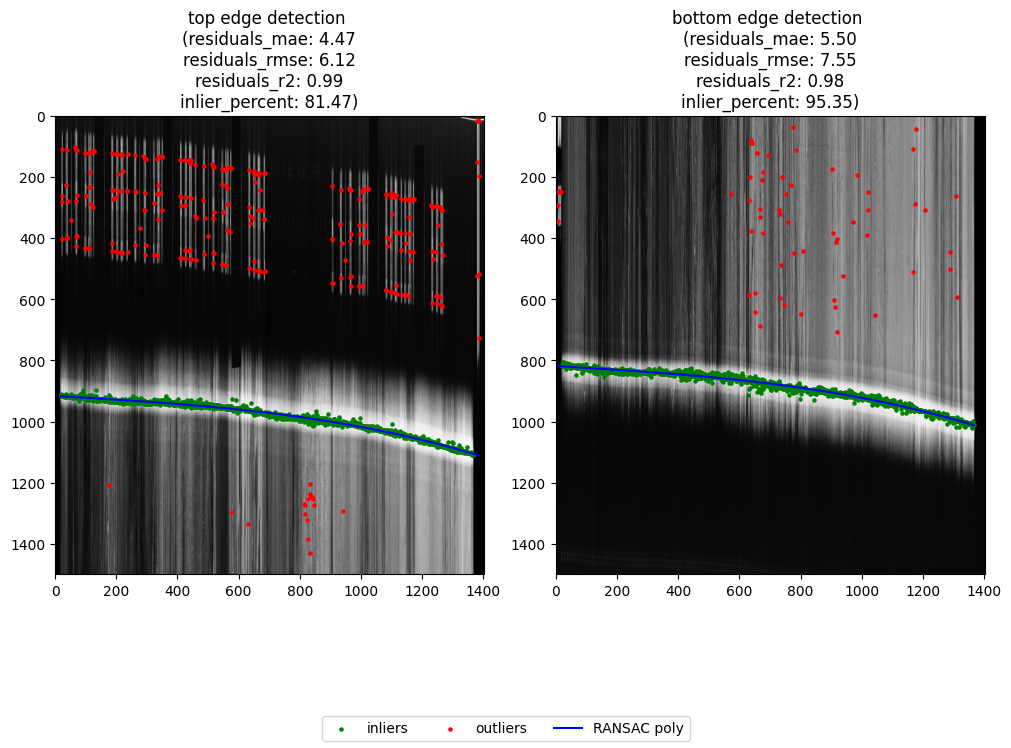

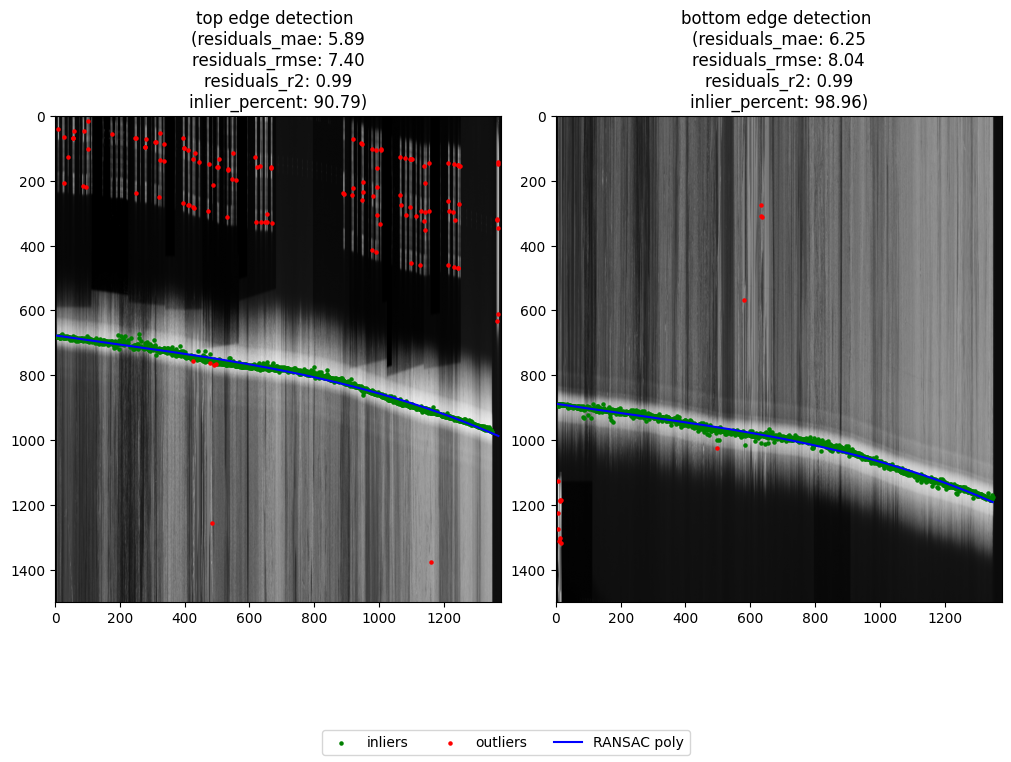

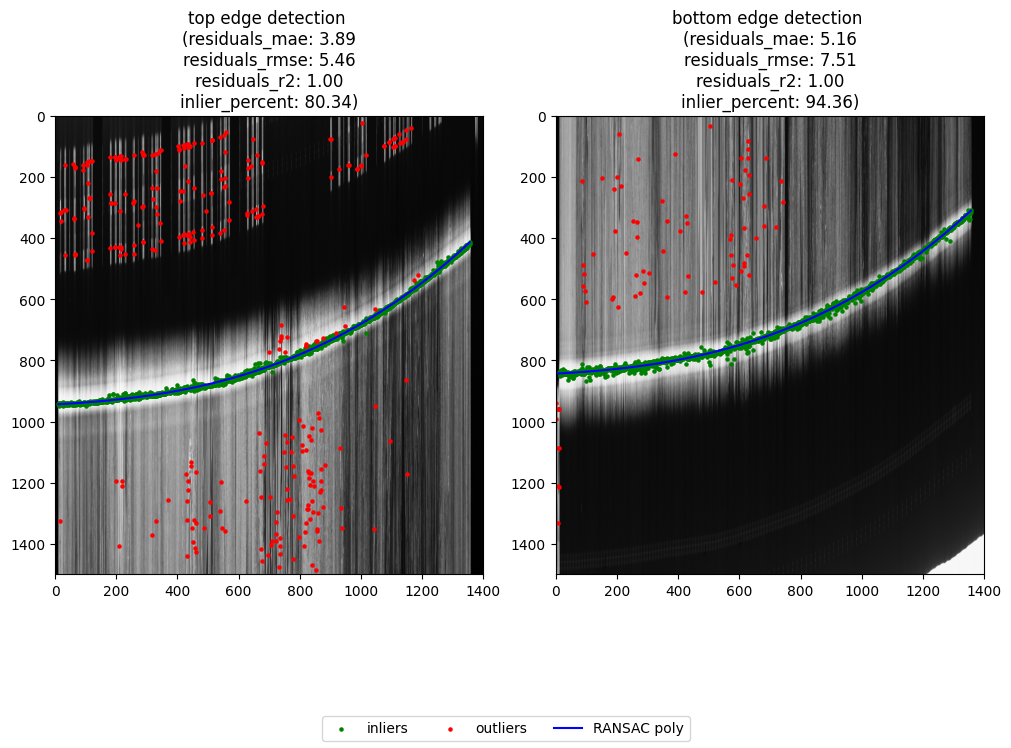

In [7]:
collimation_lines_3d_dict = {}

for raster_filepath in JOINED_IMAGES.glob("*.tif"):
    collimation_lines_3d_dict[raster_filepath.name] = hipp.kh9pc.lines_processing.detect_horizontal_collimation_lines(
        raster_filepath, polynomial_degree=3, ransac_min_samples=4, ransac_max_trials=10000, ransac_residual_threshold=50
    )

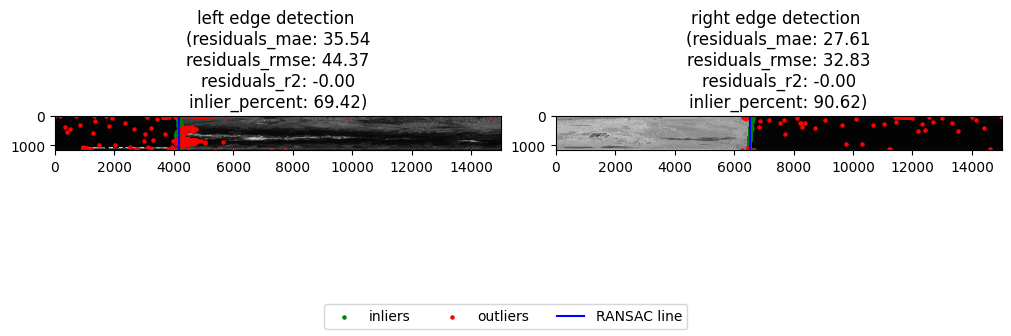

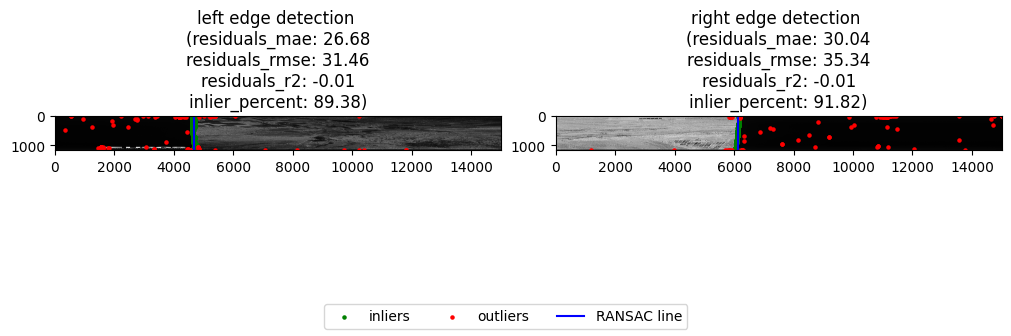

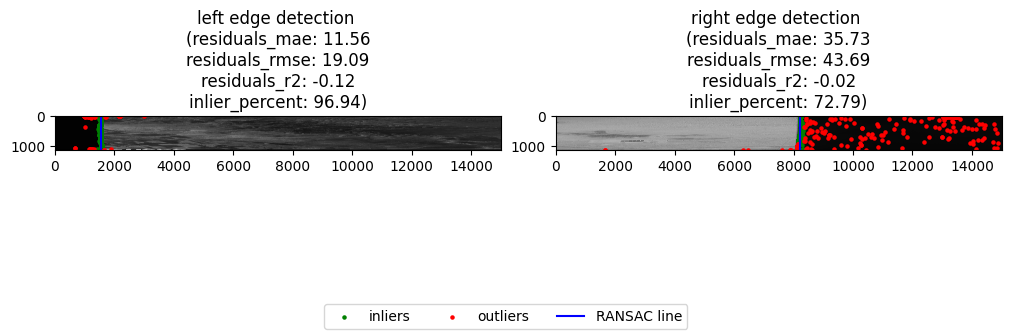

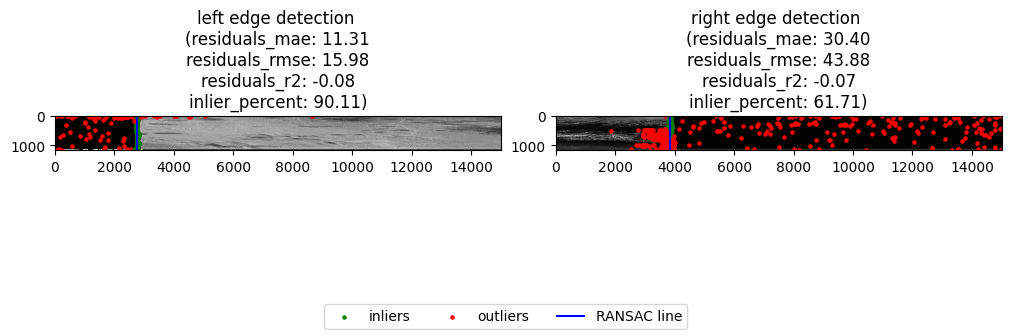

In [8]:
vertical_edges_dict = {}

for raster_filepath in JOINED_IMAGES.glob("*.tif"):
    vertical_edges_dict[raster_filepath.name] = hipp.kh9pc.lines_processing.detect_vertical_edges(raster_filepath)

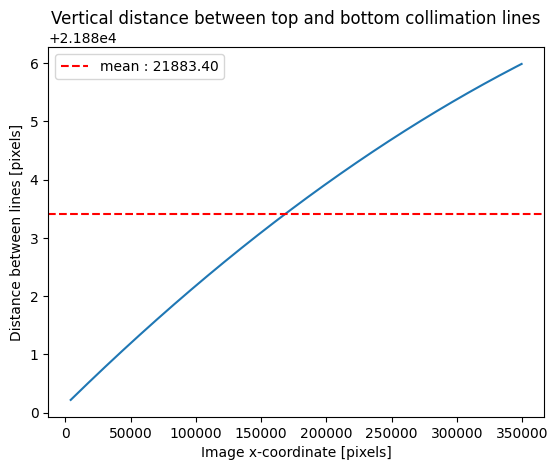

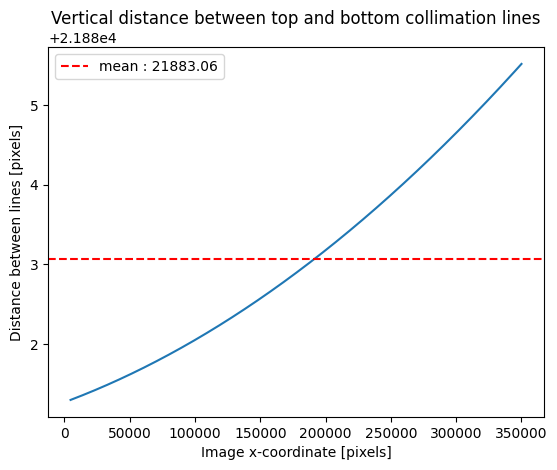

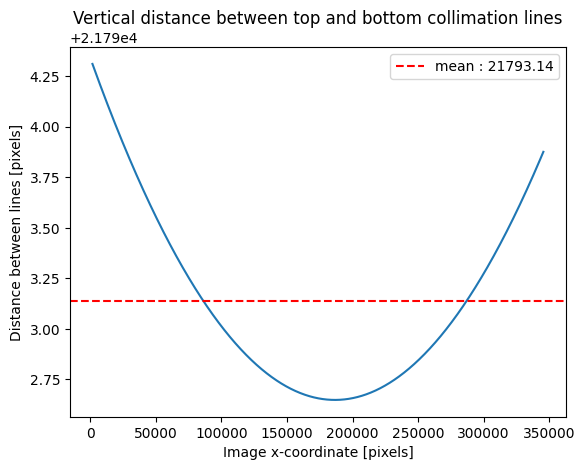

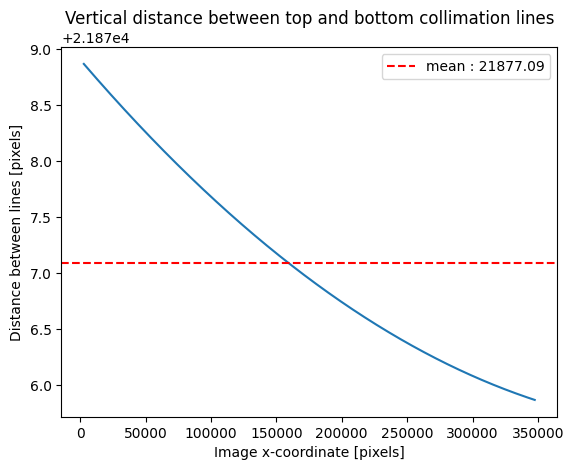

In [9]:
for raster_filepath in JOINED_IMAGES.glob("*.tif"):
    key = raster_filepath.name
    hipp.kh9pc.lines_processing.plot_distance_between_collimation_lines(vertical_edges_dict[key], collimation_lines_dict[key])

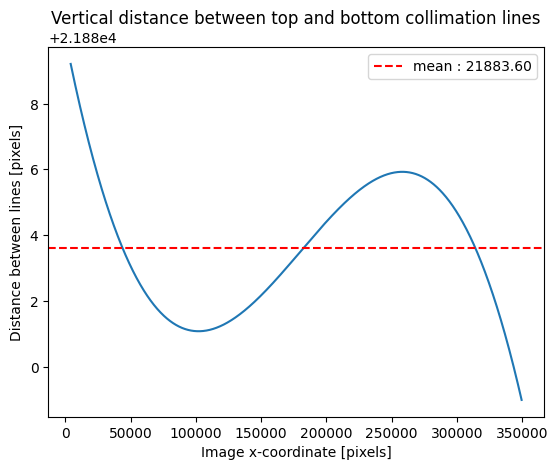

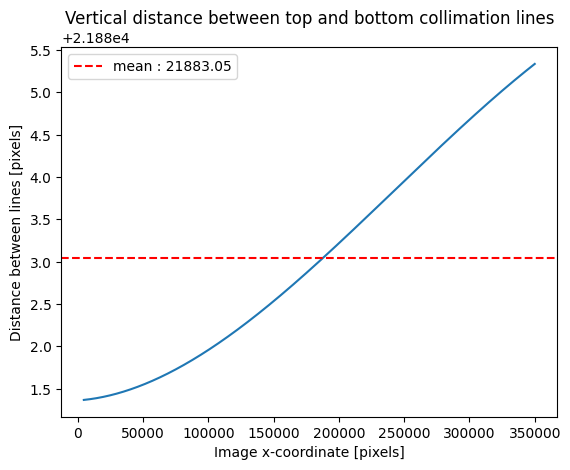

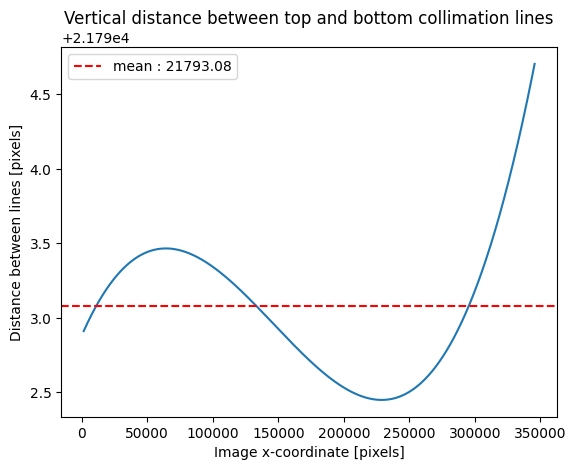

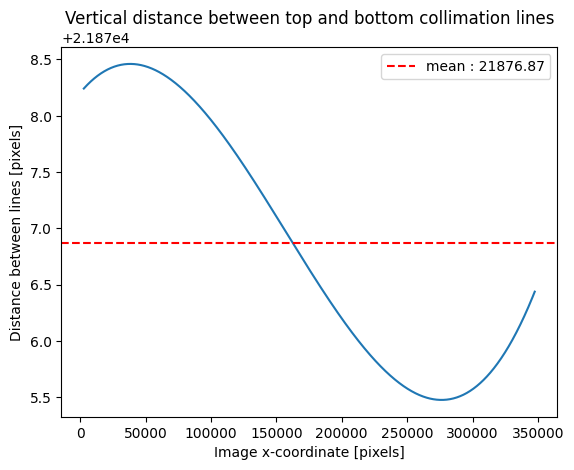

In [10]:
for raster_filepath in JOINED_IMAGES.glob("*.tif"):
    key = raster_filepath.name
    hipp.kh9pc.lines_processing.plot_distance_between_collimation_lines(vertical_edges_dict[key], collimation_lines_3d_dict[key])

In [11]:
tf_matrix_dict = {}
output_img_size_dict = {}

for raster_filepath in JOINED_IMAGES.glob("*.tif"):
    key = raster_filepath.name

    tf_matrix, output_img_size, dists = hipp.kh9pc.lines_processing.compute_transformation(vertical_edges_dict[key], collimation_lines_dict[key], plot=False)
    _, _, dists_3d = hipp.kh9pc.lines_processing.compute_transformation(vertical_edges_dict[key], collimation_lines_3d_dict[key], plot=False)

    tf_matrix_dict[key] = tf_matrix
    output_img_size_dict[key] = output_img_size
    print(f"Mean dist after transformation : {dists['mean_dist_after']:.2f} (2nd), {dists_3d['mean_dist_after']:.2f} (3nd) ")

Mean dist after transformation : 13.69 (2nd), 14.51 (3nd) 
Mean dist after transformation : 10.41 (2nd), 10.50 (3nd) 
Mean dist after transformation : 12.37 (2nd), 12.62 (3nd) 
Mean dist after transformation : 37.48 (2nd), 37.74 (3nd) 


## Warp images

In [ ]:
for raster_filepath in JOINED_IMAGES.glob("*.tif"):
    output_raster_filepath = PREPROCESSED_IMAGES / raster_filepath.name
    
    # don't overwrite
    if not output_raster_filepath.exists():
        print(f"Warping {raster_filepath} -> {output_raster_filepath}")
        hipp.image.warp_raster_pixels(raster_filepath, output_raster_filepath, tf_matrix_dict[raster_filepath.name], output_img_size_dict[raster_filepath.name])

Warping /home/godinlu/Documents/history_remote/output/test_kh9pc_preproc/casa_grande/joined_images/D3C1214-100097A013.tif -> /home/godinlu/Documents/history_remote/output/test_kh9pc_preproc/casa_grande/preprocessed_images/D3C1214-100097A013.tif
Warping /home/godinlu/Documents/history_remote/output/test_kh9pc_preproc/casa_grande/joined_images/D3C1214-100097A014.tif -> /home/godinlu/Documents/history_remote/output/test_kh9pc_preproc/casa_grande/preprocessed_images/D3C1214-100097A014.tif
Warping /home/godinlu/Documents/history_remote/output/test_kh9pc_preproc/casa_grande/joined_images/D3C1214-100097A015.tif -> /home/godinlu/Documents/history_remote/output/test_kh9pc_preproc/casa_grande/preprocessed_images/D3C1214-100097A015.tif
Warping /home/godinlu/Documents/history_remote/output/test_kh9pc_preproc/casa_grande/joined_images/D3C1214-100097F012.tif -> /home/godinlu/Documents/history_remote/output/test_kh9pc_preproc/casa_grande/preprocessed_images/D3C1214-100097F012.tif


In [13]:
hipp.tools.generate_quickviews(PREPROCESSED_IMAGES, QUICKVIEW_FACTOR, max_workers=5)

Generating quickviews: 0image [00:00, ?image/s]


## Plot the top and bottom profile after transformation

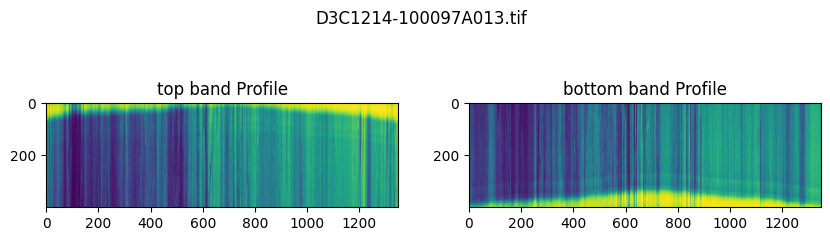

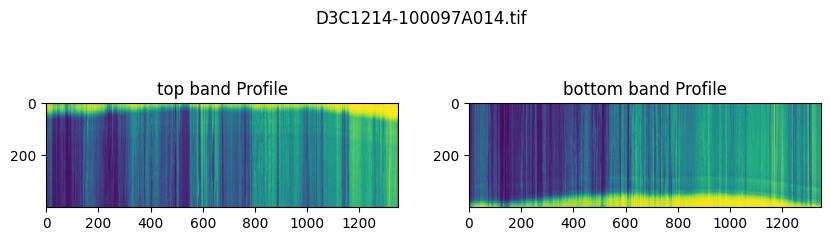

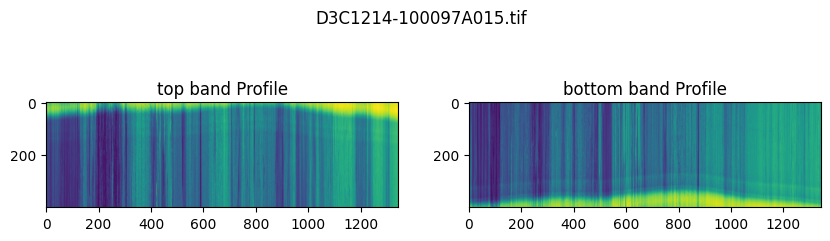

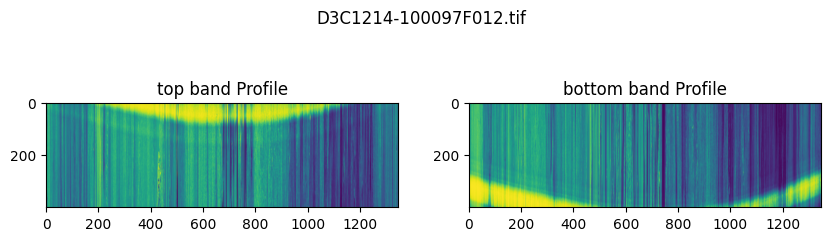

In [14]:



for raster_filepath in PREPROCESSED_IMAGES.glob("*.tif"):
    fig, axes = plt.subplots(1, 2, figsize=(10,3))
    for i, side in enumerate(["top", "bottom"]):
        band, _ = hipp.kh9pc.lines_processing.extract_raster_band_slice(raster_filepath, (0,0), band_size=400, stride=256, side=side)
        axes[i].imshow(band)
        axes[i].set_title(f"{side} band Profile")
    fig.suptitle(raster_filepath.name)

    plt.show()
